In [1]:
import os

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [3]:
plt.style.use('ggplot')

### Number of files

In [4]:
data_folder = "../data"

In [5]:
ls "../data"

 Volume in drive C is Windows
 Volume Serial Number is 384A-DC7A

 Directory of C:\Users\Abhishek\Desktop\kaggle\coursera_predict_future_sales\data

07/03/2018  11:36 PM    <DIR>          .
07/03/2018  11:36 PM    <DIR>          ..
07/03/2018  11:37 PM    <DIR>          HWTK
07/03/2018  02:13 AM             3,573 item_categories.csv
07/03/2018  02:13 AM         1,568,417 items.csv
10/09/2017  03:40 AM        94,603,866 sales_train_v2.csv
09/19/2017  06:04 AM         2,245,108 sample_submission.csv
07/03/2018  02:13 AM             2,977 shops.csv
08/08/2017  08:45 AM         3,182,735 test.csv
               6 File(s)    101,606,676 bytes
               3 Dir(s)  17,695,129,600 bytes free


In [6]:
df_item_categories = pd.read_csv(os.path.join(data_folder, "item_categories.csv"))

In [7]:
df_item_categories.head(4)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3


`item_categories.csv` contains a mapping from category_name to category_id. There are total $83$ unique categories of items. 

In [8]:
df_items = pd.read_csv(os.path.join(data_folder, "items.csv"))

In [9]:
df_items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


`items.csv` provide information for each items in the shops. This file contains the name of the item, its unique id, and the category that this item belongs to. There are total $22170$ unique items present in the shops. 

In [10]:
df_shops = pd.read_csv(os.path.join(data_folder, "shops.csv"))

In [11]:
df_shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


`shops.csv` contains the information about shops. It contains the name of each shop and the unique id associated with it. There are total $60$ shops.

In [12]:
df_sales_train = pd.read_csv(os.path.join(data_folder, "sales_train_v2.csv")) 

In [13]:
df_sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


`sales_train.csv` is the main file. It contains the information about sales of each item per day. The fileds in the data are as following:
1. *date_block_num* is a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33.
2. *date* is just the date
3. *shop_id* is the shop from which the item is purchased
4. *item_id* is the unique identifier of the item that is purchased
5. *item_price* contains the current price of the item.
6. *item_cnt_day* is the amount of item that is purchased on that particular day.

In [14]:
df_sales_train.shape

(2935849, 6)

### Q. What are the interesting information that can be gather from this data?
1. Life cycle of an item. 
2. Periodic property in the sales of an item.
3. Coorelation between price and sales for a given category

#### Popularity of items

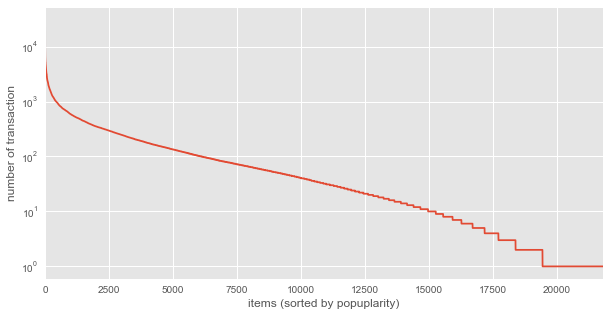

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
(df_sales_train
 .item_id
 .value_counts()
 .reset_index(drop=True)
 .plot(logy=True, ax=ax))
ax.set_xlabel("items (sorted by popuplarity)")
ax.set_ylabel("number of transaction")

As is true in most of the cases in nature, the popularity of an item is highly skewed. Some items have transactions $5000$ times and $33\%$ of the items have total sales less than 10 items in the duration of one and half year. 

#### Popularity of item categories

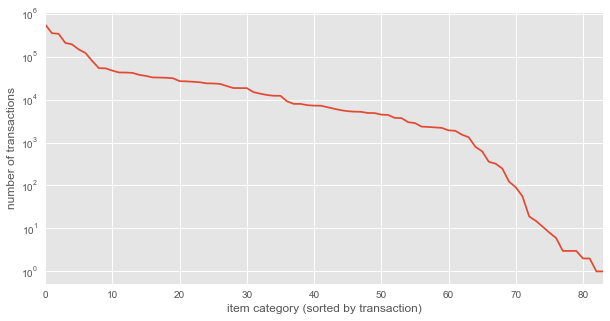

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
(df_sales_train[["item_id"]]
 .merge(df_items, on="item_id", how="left")
 .item_category_id
 .value_counts()
 .reset_index(drop=True)
 .plot(logy=True, ax=ax))
ax.set_xlabel("item category (sorted by transaction)")
ax.set_ylabel("number of transactions")

This curve looks interesting. It seems like it is form from two linear curves. We can add this feature that describes the popularity of a category.

#### Popularity of shops

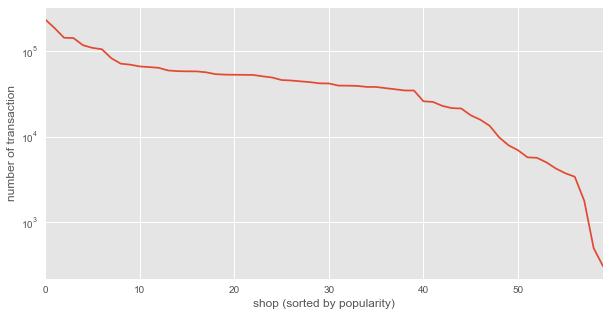

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
(df_sales_train
 .shop_id
 .value_counts()
 .reset_index(drop=True)
 .plot(logy=True))
ax.set_xlabel("shop (sorted by popularity)")
ax.set_ylabel("number of transaction")

Again very similar curve for the popularity of shops. 

#### Periodicity in the sales of an items

In [18]:
df_sales_train["date"] = pd.to_datetime(df_sales_train.date, format="%d.%m.%Y")

In [19]:
df_item_value_counts = df_sales_train.item_id.value_counts()
def get_ith_popular_item(i):
    return df_item_value_counts.index[i]

In [ ]:
def plot_sales_of_ith_popular_item(i):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    (df_sales_train
     [df_sales_train.item_id == get_ith_popular_item(i)]
     [["date_block_num", "item_cnt_day"]]
     .groupby("date_block_num")
     .aggregate("mean")
     .plot(ax=ax))
    ax.set_xlabel("month")
    ax.set_ylabel("average sale per day in that month")
    ax.legend("")
    ax.set_title("sales of {}-th popular item as month varies".format(i + 1))

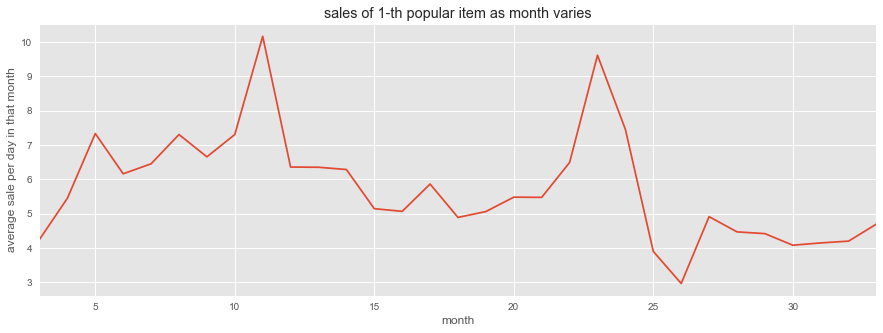

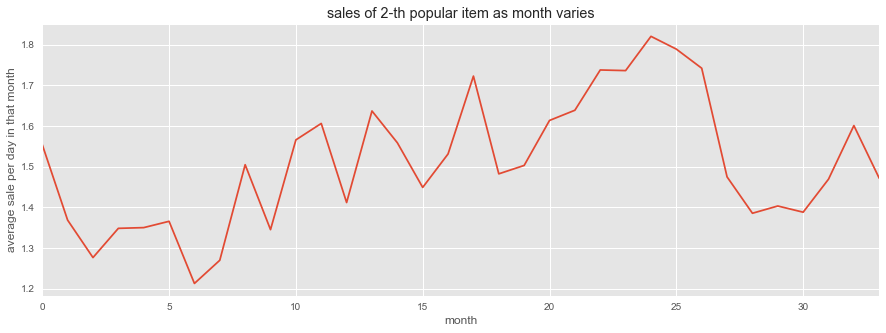

In [ ]:
plot_sales_of_ith_popular_item(0)
plot_sales_of_ith_popular_item(1)
plot_sales_of_ith_popular_item(9)
plot_sales_of_ith_popular_item(99)

Except for the most popular item, at the first glance the sales of each item doesn't seem to have much impacted by month.

#### For a given category, see how does the sales are related to price

In [ ]:
df_item_category_sales = (df_sales_train
                          [["item_id", "item_cnt_day", "item_price"]]
                          .merge(df_items, on="item_id", how="left")
                          .groupby("item_category_id"))

In [ ]:
popular_categories = (df_item_category_sales
                      .size()
                      .sort_values(ascending=False)
                      .index)

In [ ]:
def plot_sale_vs_price_for_category(i):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    (df_item_category_sales
     .get_group(i)
     .groupby("item_id")
     .aggregate({"item_price": "mean", "item_cnt_day": sum})
     .sort_values("item_price")
     .plot.scatter(x="item_price", y="item_cnt_day", ax=ax, legend=False, logy=True, logx=True))
    ax.set_xlabel("average item price")
    ax.set_ylabel("toal sales")
    ax.set_title("sales of items as a function of price in {}-th category".format(i))

In [ ]:
plot_sale_vs_price_for_category(popular_categories[0])
plot_sale_vs_price_for_category(popular_categories[10])

Price does not seem to have an impace on sales. In a category, there will be similar items. For similar items, price might be a key factor in deciding the sales.

#### How to find similar items in a category by their name information

### Can you guess how the training data and test data is generated?

If I would be a data collector, I will store the data as following
1. For training, I will store the sales information of each item.
2. For testing, I will just gather each item and see how many times they are sold.

*There is a problem with this approach. During training, I will not have any item that is never traded. But it is fairly possible in testing.*

### Test data Set

In [ ]:
df_test = pd.read_csv(os.path.join(data_folder, "test.csv"))

In [ ]:
df_test.head()

We are given only `shop_id` and `item_id`. We need to predict sales only from this.

**What are the histograms that I can build for this data?**

In [ ]:
months = ["Jan", "Feb", "March", "April", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]
years = ["13", "14", "15"]

In [ ]:
from itertools import product

In [ ]:
months_years = [m + " " + y for y, m in product(years, months)]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(19, 5))
(df_sales_train
 .date_block_num
 .value_counts()
 .sort_index()
 .plot.bar(ax=ax))
ax.set_xlabel("Sequence of Month")
ax.set_ylabel("Total foot traffic")
ax.set_xticklabels(months_years, rotation=45);

Clearly, we see that there is a jump in the month of December which indicates `Christmas sales`. I am surprised to see not much `Thanksgiving sales` then I realized that it is Russia.  

**Hypothesis:** The foot traffic is decreasing for the shops. 

In [ ]:
df_sales_train["year"] = df_sales_train.date.dt.year
df_sales_train["month"] = df_sales_train.date.dt.month
df_sales_train["day"] = df_sales_train.date.dt.day

In [ ]:
df_sales_train["spending"] = df_sales_train["item_cnt_day"] * df_sales_train["item_price"]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
(df_sales_train
 .groupby("year")
 .agg({"spending": "mean", "item_cnt_day": ["sum", len]})
 .plot.bar(ax=ax, subplots=True, layout=(2, 2)))
ax.set_xlabel("Year")
ax.set_ylabel("Total foot traffic")
ax.set_xticklabels(years, rotation=0)
fig.tight_layout();

**Key Insights:** People bought significantly less items in 2015 but they spent lot more money. This observation can be attributed to `Russian Financial Crisis` between 2014 and 2017. During this time, price of items were increased [wikipedia](https://en.wikipedia.org/wiki/Russian_financial_crisis_(2014%E2%80%932017). *This observation suggests that I should give more weightage to the recent datapoints.*

#### What kind of items are in the train data set?

In [ ]:
ls "../data"

#### Given this much information, how will you build a model? Did you seen any specific feature that stands out?